# Sensor Variables in Data
| Index	| Symbol | Description | Unit |
| --- | --- | --- | --- |
| 1	| T2 | Total | temperature at fan inlet | °R |
| 2	| T24 | Total temperature at LPC outlet | °R |
| 3	| T30 | Total temperature at HPC outlet | °R |
| 4	| T50 | Total temperature at LPT outlet | °R |
| 5	| P2 | Pressure at fan inlet | psia |
| 6	| P15 | Total pressure in bypass-duct | psia |
| 7	| P30 | Total pressure at HPC outlet | psia |
| 8	| Nf | Physical fan speed | rpm |
| 9	| Nc | Physical core speed | rpm |
| 10 | epr | Engine pressure ratio (P50/P2) | — |
| 11 | Ps30 | Static pressure at HPC outlet | psia |
| 12 | phi | Ratio of fuel flow to Ps30 | pps/psi |
| 13 | NRf | Corrected fan speed | rpm |
| 14 | NRc | Corrected core speed | rpm |
| 15 | BPR | Bypass ratio | — |
| 16 | farB | Burner fuel-air ratio | — |
| 17 | htBleed | Bleed enthalpy | — |
| 18 | Nf_dmd | Demanded fan speed | rpm |
| 19 | PCNFR_dmd | Demanded corrected fan speed | rpm |
| 20 | W31	HPT | coolant bleed | lbm/s |
| 21 | W32	LPT | coolant bleed | lbm/s |

# TODO
1. Need to implement better data sanitization
  1. Normalization
  2. Smoothing
2. Need to verify the Keras models

# Import libraries
Do it in one block so we don't miss any.

In [3]:
from math import sqrt

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from pandas import read_csv, merge
from seaborn import lmplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define some constants
We'll (sadly) make use of these globally.

In [4]:
# Labels for our data files
DATA_LABELS = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
               's17', 's18', 's19', 's20', 's21']

# Threshold for our simple cut on standard deviation
STDDEV_THRESHOLD = 0.00001

# Define some useful functions

In [5]:
def read_data_from_file(file_name):
    """
    Reads the space separated data from the specified path. We're expecting
    the files to be Space separated, so we've statically defined the delimiter. We're also
    making use of our global labels to truncate the last two columns from the files. They
    seemed to have some extra spaces at the end.
    :param file_name: The file that we're going to open
    :return: A Pandas DF containing the data
    """
    return read_csv(file_name, delimiter=" ", names=DATA_LABELS, usecols=range(len(DATA_LABELS)))

def filter_data_frame_by_stddev(df, stddev_threshold):
    """
    Filters all columns of the data
    :param df: The data frame that we're going to filter.
    :param stddev_threshold: The threshold that we'll filter at.
    :return: Data frame missing the columns with a STDDEV under threshold
    """
    return df.drop(df.std()[df.std() < stddev_threshold].index.values, axis=1)

def add_rul_to_data_frame(df):
    """
    Adds the remaining useful life (RUL) metric to the data frame.
    :param df: The data frame we want to add the RUL to
    :return:
    """
    df1 = merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
    df1.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
    df1['RUL'] = df1['maxcycles'] - df1['cycles']
    return df1.drop("maxcycles", axis=1)

# Import our training data

In [6]:
train_df_raw = read_data_from_file("../Data/train_FD001.txt")
training_df_filtered = filter_data_frame_by_stddev(train_df_raw, STDDEV_THRESHOLD)
training_df_filtered_w_rul = add_rul_to_data_frame(training_df_filtered)
training_array_x = training_df_filtered_w_rul.drop(["unit", 'RUL'], axis = 1).values
training_array_y = training_df_filtered_w_rul['RUL'].values

# Import our test data

In [7]:
test_df_raw = read_data_from_file("../Data/test_FD001.txt")
test_df_filtered = filter_data_frame_by_stddev(test_df_raw, STDDEV_THRESHOLD)
test_df_filtered_w_rul = add_rul_to_data_frame(test_df_filtered)
test_array_x = test_df_filtered_w_rul.drop(["unit", 'RUL'], axis = 1).values
test_array_for_predictions = (test_df_filtered[test_df_filtered.groupby(['unit'])['cycles'].transform(max) == test_df_filtered['cycles']]).drop(["unit"], axis=1).values

# Implement simple regression

In [8]:
simple_regression = LinearRegression().fit(training_array_x, training_array_y)
print(simple_regression.coef_)
print(simple_regression.intercept_)


[-3.99640778e-01 -6.14378103e+01  2.43416877e+03 -5.32978571e+00
 -2.71006100e-01 -4.49405046e-01 -4.89501669e+02  4.19807458e+00
 -2.72972639e+01 -1.64408021e-01 -2.39529116e+01  5.72435199e+00
 -1.96394176e+01 -1.37355741e-01 -7.98539951e+01 -9.77215078e-01
  9.75703300e+00  2.43794617e+01]
125859.9919738139


## Perform our predictions on the test data

In [9]:
simple_predictions = simple_regression.predict(test_array_for_predictions)

## Read in the actual values for the data

In [10]:
rul = read_csv("../Data/RUL_FD001.txt", names=["RUL"])

## Join the actuals with the simple predictions

In [11]:
rul['simple_predictions'] = simple_predictions

## Simple Prediction vs. RUL

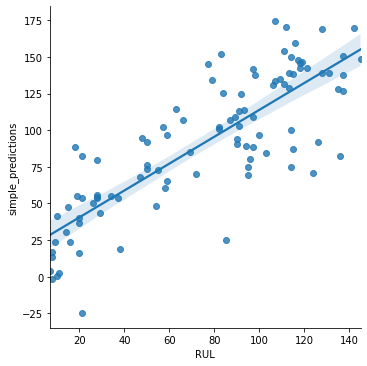

In [12]:
lmplot(x='RUL', y='simple_predictions', data=rul, fit_reg=True)

## Simple prediction RMS

In [13]:
sqrt(mean_squared_error(rul['RUL'], rul['simple_predictions']))

31.25047411764633

# Implement Keras regression

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=18, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

print(model.summary())
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(training_array_x, training_array_x, epochs=100)

## Make our predictions

In [ ]:
keras_predictions = model.predict(test_array_for_predictions)

## Join the actuals with the simple predictions

In [ ]:
rul['keras_predictions'] = keras_predictions

## Keras Prediction vs. RUL

In [ ]:
lmplot(x='RUL', y='keras_predictions', data=rul, fit_reg=True)

## Keras prediction RMS

In [ ]:
sqrt(mean_squared_error(rul['RUL'], rul['keras_predictions']))
